# CNN Exploration: Mars Surface Image Classification

This notebook explores **Convolutional Neural Networks (CNNs)** using the **Mars Surface Image Dataset** collected by NASA's Curiosity rover. The dataset contains 6,691 images spanning 24 classes captured by three instruments: Mastcam Right eye, Mastcam Left eye, and MAHLI.

**Dataset Citation:**
> Kiri L. Wagstaff, You Lu, Alice Stanboli, Kevin Grimes, Thamme Gowda, and Jordan Padams. "Deep Mars: CNN Classification of Mars Imagery for the PDS Imaging Atlas." *Proceedings of the Thirtieth Annual Conference on Innovative Applications of Artificial Intelligence*, 2018.

**DOI:** [10.5281/zenodo.1049137](https://doi.org/10.5281/zenodo.1049137)

## 1. Dataset Exploration (EDA)

In this section, we will perform an **Exploratory Data Analysis (EDA)** on the Mars Surface Image dataset to understand:

- **Dataset size and class distribution**
- **Image dimensions and channels**
- **Examples of samples per class**
- **Preprocessing applied (normalization, resizing)**

### 1.1 Import Required Libraries

In [6]:
import numpy as np
import matplotlib.pyplot as plt
import os
from PIL import Image
from collections import Counter
import pandas as pd

# Set random seed for reproducibility
np.random.seed(42)

# Define paths
BASE_PATH = 'msl-images'
CALIBRATED_PATH = os.path.join(BASE_PATH, 'calibrated')
TRAIN_FILE = os.path.join(BASE_PATH, 'train-calibrated-shuffled.txt')
VAL_FILE = os.path.join(BASE_PATH, 'val-calibrated-shuffled.txt')
TEST_FILE = os.path.join(BASE_PATH, 'test-calibrated-shuffled.txt')
SYNSET_FILE = os.path.join(BASE_PATH, 'msl_synset_words-indexed.txt')

print("Libraries imported successfully!")

Libraries imported successfully!


### 1.2 Load Class Labels (Synset Words)

The dataset contains **24 different classes** representing various objects and features observed on Mars. Let's load the class mapping.

In [7]:
# Load class names from synset file
def load_class_names(synset_path):
    """Load class ID to class name mapping from synset file."""
    class_names = {}
    with open(synset_path, 'r') as f:
        for line in f:
            parts = line.strip().split('\t')
            if len(parts) >= 2:
                class_id = int(parts[0])
                class_name = parts[1]
                class_names[class_id] = class_name
    return class_names

class_names = load_class_names(SYNSET_FILE)

print(f"Total number of classes: {len(class_names)}")
print("\nClass ID -> Class Name mapping:")
print("-" * 40)
for class_id, name in sorted(class_names.items()):
    print(f"  {class_id:2d}: {name}")

Total number of classes: 0

Class ID -> Class Name mapping:
----------------------------------------


### 1.3 Load Dataset Labels and Analyze Distribution

The dataset is divided into **train**, **validation**, and **test** sets according to their sol (Martian day) of acquisition. This temporal split models how the system would be used operationally with an image archive that grows over time.

In [8]:
def load_dataset_labels(file_path):
    """Load image paths and labels from a dataset file."""
    images = []
    labels = []
    with open(file_path, 'r') as f:
        for line in f:
            parts = line.strip().split()
            if len(parts) >= 2:
                img_path = parts[0]
                label = int(parts[1])
                images.append(img_path)
                labels.append(label)
    return images, labels

# Load all datasets
train_images, train_labels = load_dataset_labels(TRAIN_FILE)
val_images, val_labels = load_dataset_labels(VAL_FILE)
test_images, test_labels = load_dataset_labels(TEST_FILE)

# Calculate dataset sizes
total_images = len(train_images) + len(val_images) + len(test_images)

print("=" * 50)
print("DATASET SIZE SUMMARY")
print("=" * 50)
print(f"Training set:   {len(train_images):,} images ({len(train_images)/total_images*100:.1f}%)")
print(f"Validation set: {len(val_images):,} images ({len(val_images)/total_images*100:.1f}%)")
print(f"Test set:       {len(test_images):,} images ({len(test_images)/total_images*100:.1f}%)")
print("-" * 50)
print(f"TOTAL:          {total_images:,} images")
print("=" * 50)

DATASET SIZE SUMMARY
Training set:   3,746 images (56.0%)
Validation set: 1,640 images (24.5%)
Test set:       1,305 images (19.5%)
--------------------------------------------------
TOTAL:          6,691 images


### 1.4 Class Distribution Analysis

Let's analyze how the images are distributed across the 24 classes. Understanding class imbalance is crucial for training neural networks.

In [9]:
# Count samples per class for each dataset
train_counts = Counter(train_labels)
val_counts = Counter(val_labels)
test_counts = Counter(test_labels)
total_counts = Counter(train_labels + val_labels + test_labels)

# Create DataFrame for visualization
distribution_data = []
for class_id in sorted(class_names.keys()):
    distribution_data.append({
        'Class ID': class_id,
        'Class Name': class_names[class_id],
        'Train': train_counts.get(class_id, 0),
        'Val': val_counts.get(class_id, 0),
        'Test': test_counts.get(class_id, 0),
        'Total': total_counts.get(class_id, 0)
    })

df_distribution = pd.DataFrame(distribution_data)
print("Class Distribution Summary:")
print(df_distribution.to_string(index=False))

Class Distribution Summary:
Empty DataFrame
Columns: []
Index: []


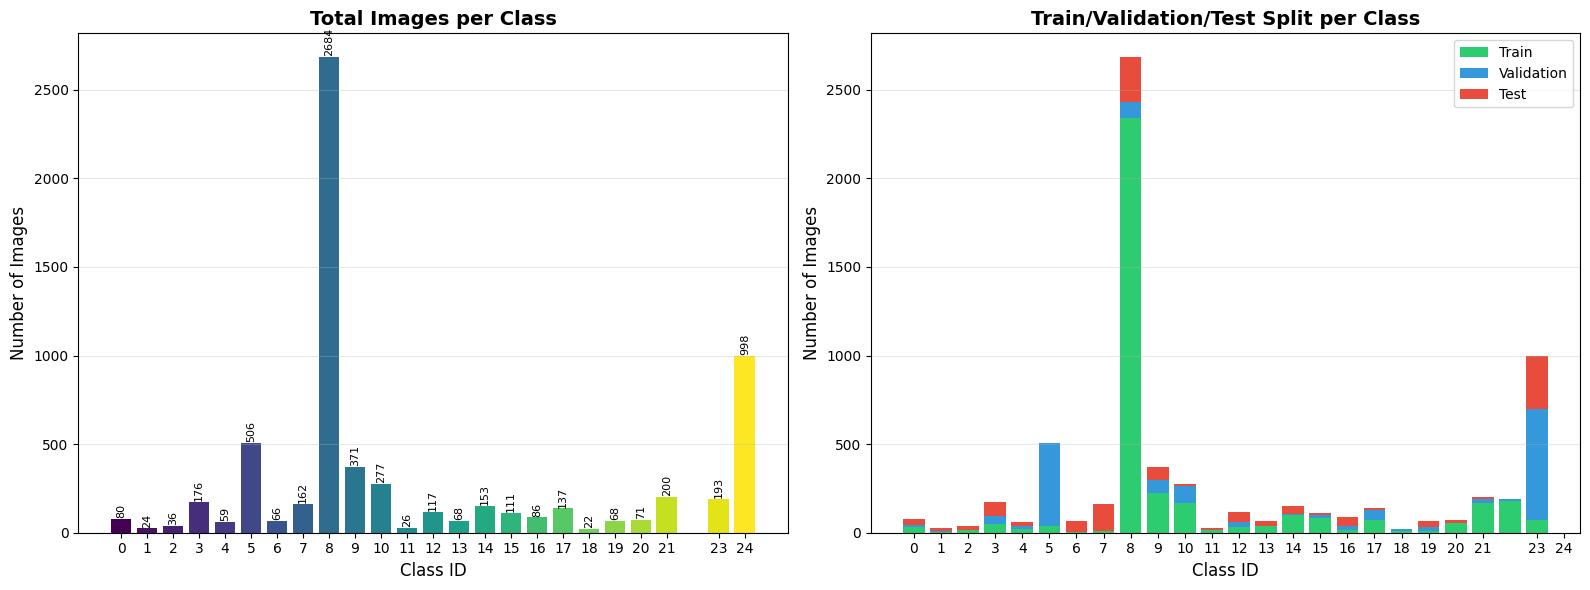


CLASS IMBALANCE ANALYSIS
Most frequent class:  Class_8 (ID: 8) - 2684 images
Least frequent class: Class_18 (ID: 18) - 22 images
Imbalance ratio:      122.00x


In [19]:
# Check if class_names is loaded properly, if not use class IDs from data
if not class_names:
    print("Warning: class_names dictionary is empty. Using class IDs from data.")
    # Get all unique class IDs from the data
    all_class_ids = set(train_labels + val_labels + test_labels)
    class_names = {i: f"Class_{i}" for i in sorted(all_class_ids)}
    print(f"Found {len(class_names)} classes: {sorted(class_names.keys())}")

# Visualize class distribution
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Get all class IDs that exist in the data
class_ids = sorted(class_names.keys())
totals = [total_counts.get(i, 0) for i in class_ids]
colors = plt.cm.viridis(np.linspace(0, 1, len(class_ids)))

ax1 = axes[0]
bars = ax1.bar(class_ids, totals, color=colors)
ax1.set_xlabel('Class ID', fontsize=12)
ax1.set_ylabel('Number of Images', fontsize=12)
ax1.set_title('Total Images per Class', fontsize=14, fontweight='bold')
ax1.set_xticks(class_ids)
ax1.grid(axis='y', alpha=0.3)

# Add value labels on top of bars
for bar, total in zip(bars, totals):
    if total > 0:
        ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 5, 
                str(total), ha='center', va='bottom', fontsize=8, rotation=90)

# Stacked bar chart - Train/Val/Test split per class
ax2 = axes[1]
train_vals = [train_counts.get(i, 0) for i in class_ids]
val_vals = [val_counts.get(i, 0) for i in class_ids]
test_vals = [test_counts.get(i, 0) for i in class_ids]

x = np.arange(len(class_ids))
width = 0.8

ax2.bar(x, train_vals, width, label='Train', color='#2ecc71')
ax2.bar(x, val_vals, width, bottom=train_vals, label='Validation', color='#3498db')
ax2.bar(x, test_vals, width, bottom=np.array(train_vals)+np.array(val_vals), label='Test', color='#e74c3c')

ax2.set_xlabel('Class ID', fontsize=12)
ax2.set_ylabel('Number of Images', fontsize=12)
ax2.set_title('Train/Validation/Test Split per Class', fontsize=14, fontweight='bold')
ax2.set_xticks(class_ids)
ax2.legend()
ax2.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

# Print class imbalance statistics
if totals:  # Check if we have data
    max_class_id = max(total_counts, key=total_counts.get)
    min_class_id = min(total_counts, key=total_counts.get)
    max_count = max(totals)
    min_count = min([t for t in totals if t > 0])  # Avoid zero values
    
    print("\n" + "=" * 50)
    print("CLASS IMBALANCE ANALYSIS")
    print("=" * 50)
    print(f"Most frequent class:  {class_names[max_class_id]} (ID: {max_class_id}) - {max_count} images")
    print(f"Least frequent class: {class_names[min_class_id]} (ID: {min_class_id}) - {min_count} images")
    print(f"Imbalance ratio:      {max_count/min_count:.2f}x")
    print("=" * 50)
else:
    print("No data found to analyze class imbalance.")

### 1.5 Image Dimensions and Channels Analysis

Let's examine the actual image properties including dimensions and color channels.

Analyzing image dimensions...

IMAGE DIMENSIONS ANALYSIS
Sample size analyzed: 100 images
--------------------------------------------------
Width  - Min: 255, Max: 256, Mean: 255.6
Height - Min: 127, Max: 256, Mean: 213.3
--------------------------------------------------
Unique dimensions found: 22
Most common dimension: ((255, 255), 17)
--------------------------------------------------
Image modes found: {'RGB', 'L'}
Number of channels: {1, 3}


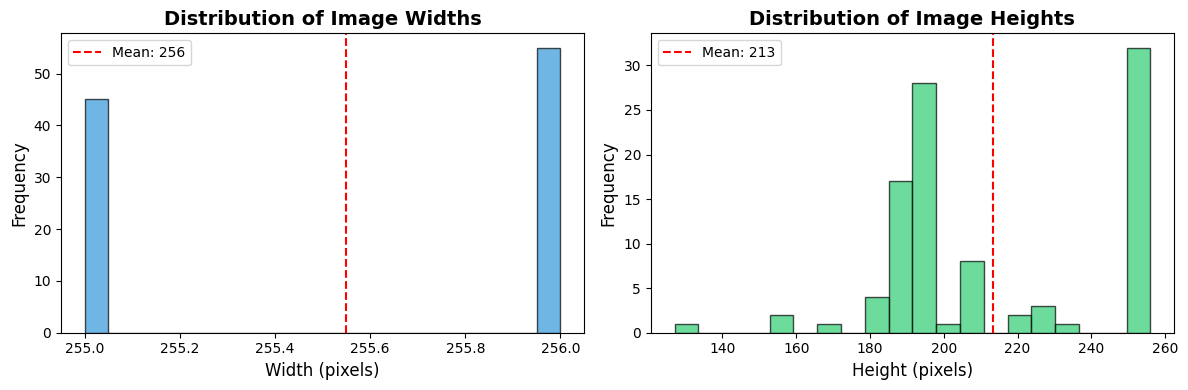

In [20]:
# Sample random images to analyze dimensions
sample_size = min(100, len(train_images))
sample_indices = np.random.choice(len(train_images), sample_size, replace=False)

dimensions = []
channels_list = []
modes = []

print("Analyzing image dimensions...")
for idx in sample_indices:
    img_path = os.path.join(BASE_PATH, train_images[idx])
    if os.path.exists(img_path):
        img = Image.open(img_path)
        dimensions.append(img.size)  # (width, height)
        if img.mode == 'RGB':
            channels_list.append(3)
        elif img.mode == 'L':
            channels_list.append(1)
        else:
            channels_list.append(len(img.mode))
        modes.append(img.mode)
        img.close()

# Analyze dimensions
widths = [d[0] for d in dimensions]
heights = [d[1] for d in dimensions]

print("\n" + "=" * 50)
print("IMAGE DIMENSIONS ANALYSIS")
print("=" * 50)
print(f"Sample size analyzed: {len(dimensions)} images")
print("-" * 50)
print(f"Width  - Min: {min(widths)}, Max: {max(widths)}, Mean: {np.mean(widths):.1f}")
print(f"Height - Min: {min(heights)}, Max: {max(heights)}, Mean: {np.mean(heights):.1f}")
print("-" * 50)
print(f"Unique dimensions found: {len(set(dimensions))}")
print(f"Most common dimension: {Counter(dimensions).most_common(1)[0]}")
print("-" * 50)
print(f"Image modes found: {set(modes)}")
print(f"Number of channels: {set(channels_list)}")
print("=" * 50)

# Visualize dimension distribution
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

ax1 = axes[0]
ax1.hist(widths, bins=20, color='#3498db', edgecolor='black', alpha=0.7)
ax1.set_xlabel('Width (pixels)', fontsize=12)
ax1.set_ylabel('Frequency', fontsize=12)
ax1.set_title('Distribution of Image Widths', fontsize=14, fontweight='bold')
ax1.axvline(np.mean(widths), color='red', linestyle='--', label=f'Mean: {np.mean(widths):.0f}')
ax1.legend()

ax2 = axes[1]
ax2.hist(heights, bins=20, color='#2ecc71', edgecolor='black', alpha=0.7)
ax2.set_xlabel('Height (pixels)', fontsize=12)
ax2.set_ylabel('Frequency', fontsize=12)
ax2.set_title('Distribution of Image Heights', fontsize=14, fontweight='bold')
ax2.axvline(np.mean(heights), color='red', linestyle='--', label=f'Mean: {np.mean(heights):.0f}')
ax2.legend()

plt.tight_layout()
plt.show()

### 1.6 Sample Images Visualization

Let's visualize sample images from each class to understand what the rover captured on Mars.

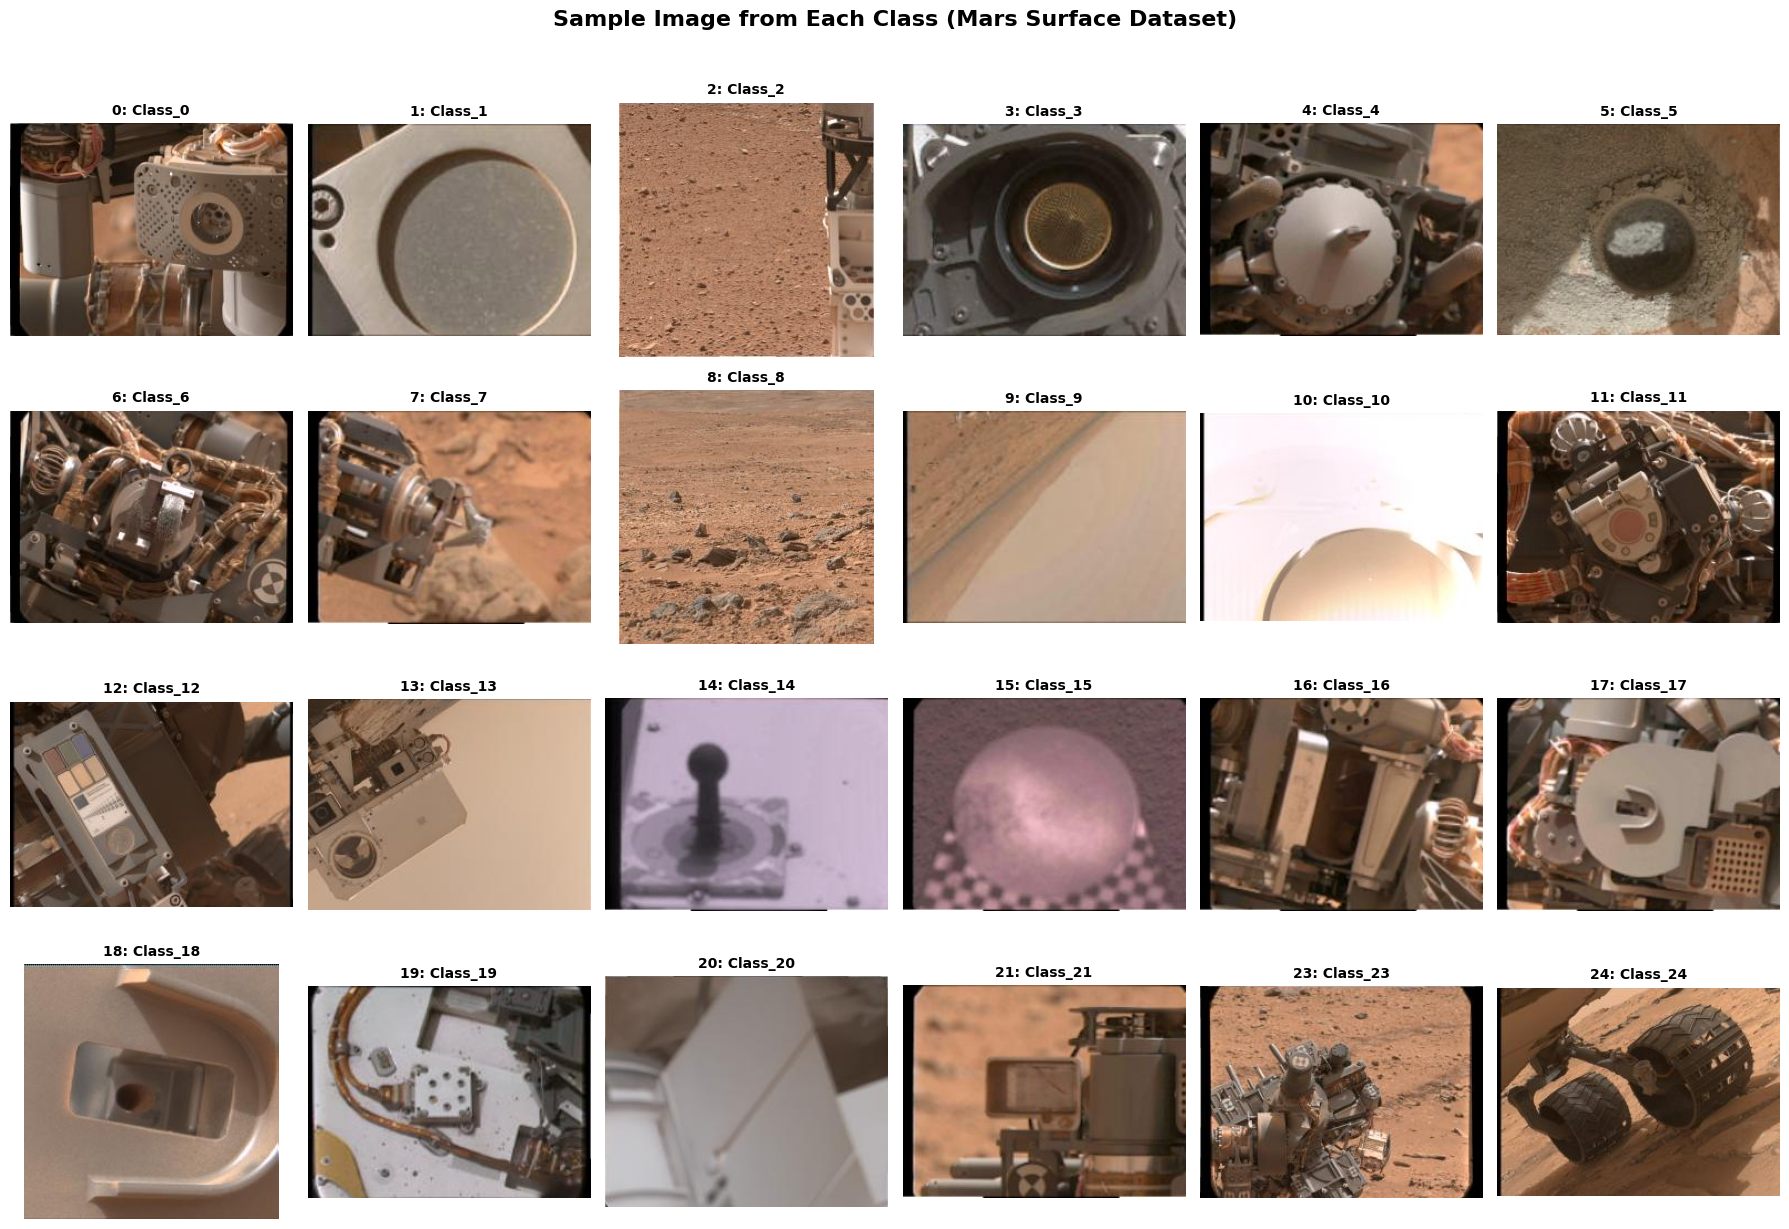

In [22]:
# Create a dictionary of images per class for all classes that exist in the data
all_labels = set(train_labels + val_labels + test_labels)
images_by_class = {i: [] for i in all_labels}
for img, label in zip(train_images, train_labels):
    images_by_class[label].append(img)
# Display one sample image from each class
available_classes = sorted(images_by_class.keys())
n_classes = len(available_classes)
n_cols = 6
n_rows = (n_classes + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(18, 3*n_rows))
axes = axes.flatten()

for idx, class_id in enumerate(available_classes):
    ax = axes[idx]
    if images_by_class[class_id]:
        # Get a random sample from this class
        sample_img_path = os.path.join(BASE_PATH, np.random.choice(images_by_class[class_id]))
        if os.path.exists(sample_img_path):
            img = Image.open(sample_img_path)
            ax.imshow(img)
            img.close()
    ax.set_title(f"{class_id}: {class_names.get(class_id, f'Class_{class_id}')}", fontsize=10, fontweight='bold')
    ax.axis('off')

# Turn off remaining empty subplots
for idx in range(n_classes, len(axes)):
    axes[idx].axis('off')
    axes[idx].axis('off')

plt.suptitle('Sample Image from Each Class (Mars Surface Dataset)', fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

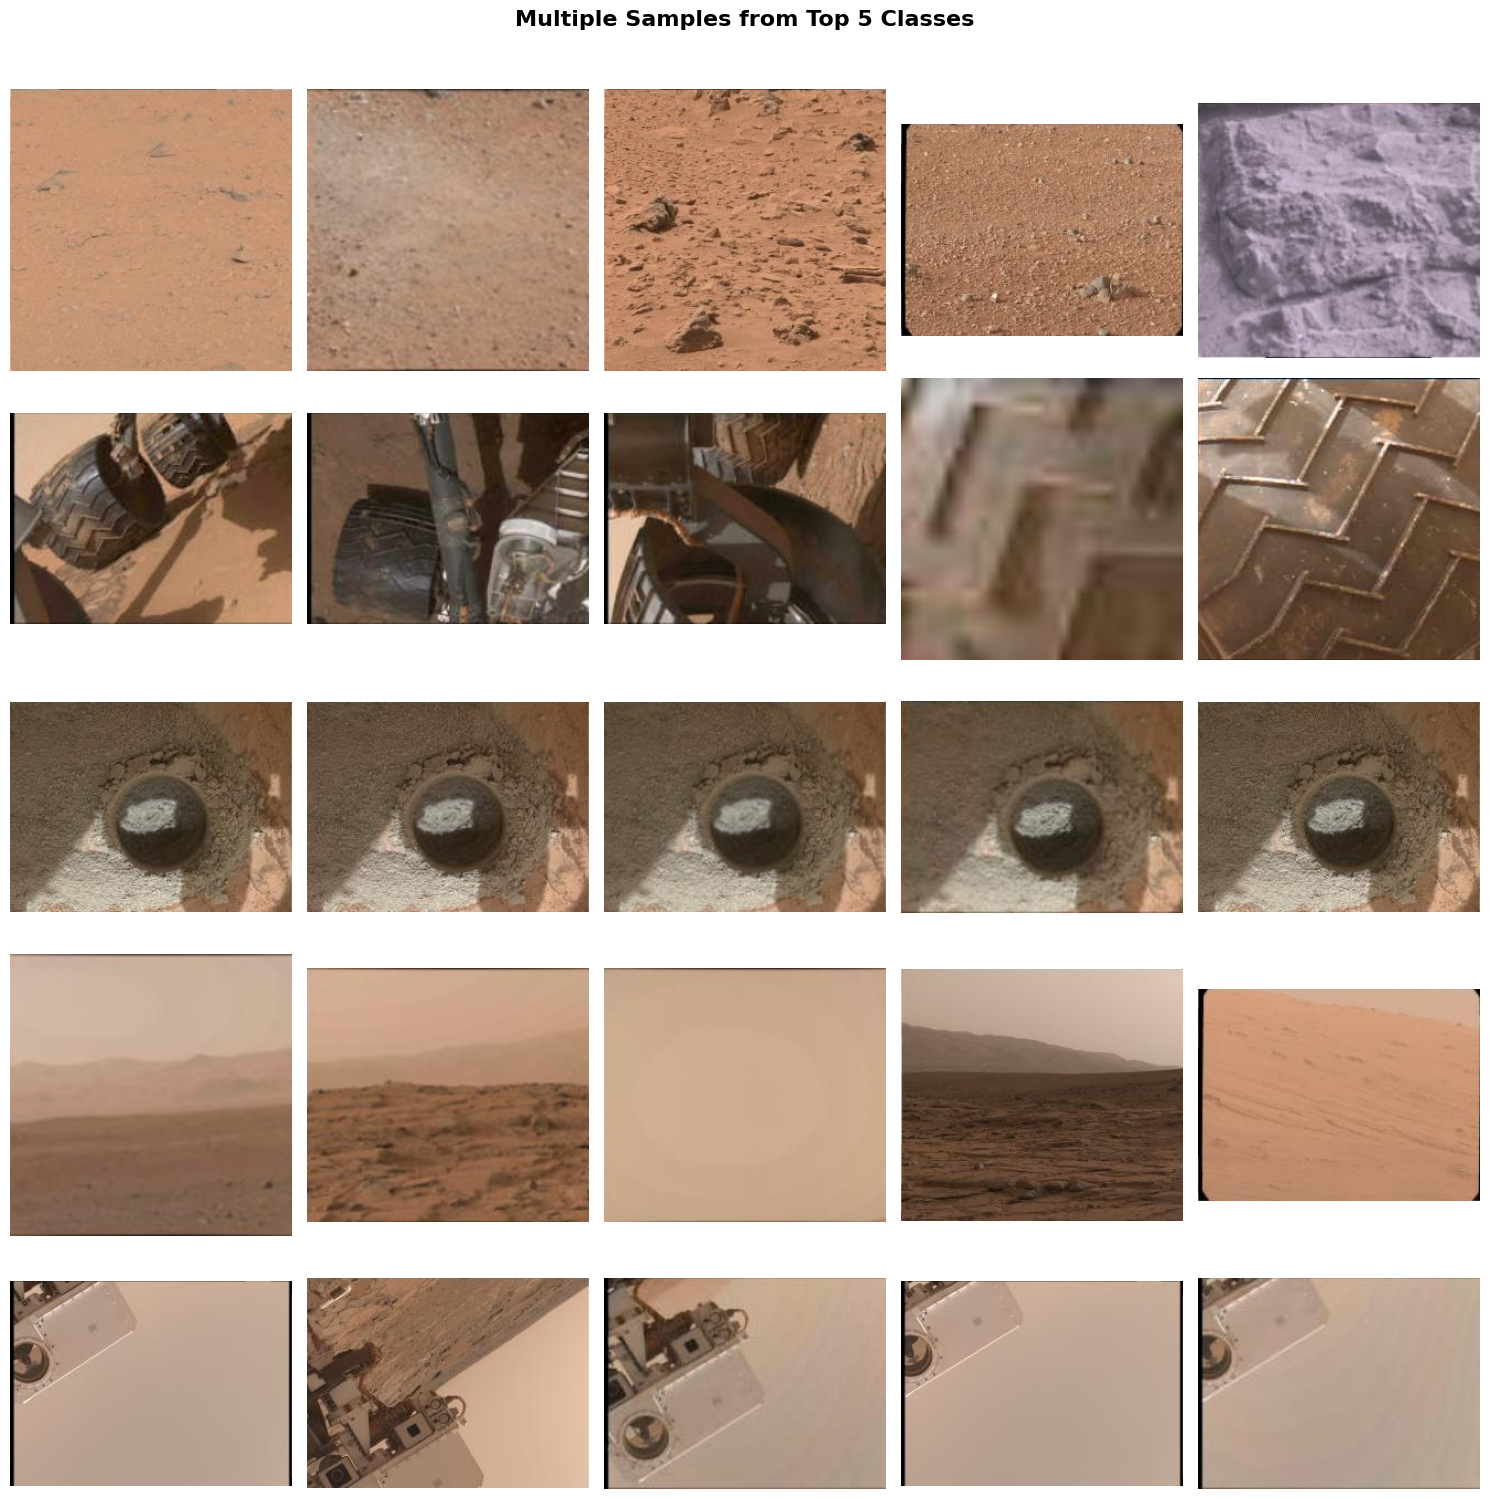

In [23]:
# Display multiple samples from selected classes (most frequent ones)
top_classes = [8, 24, 5, 9, 13]  # ground, wheel, drill holes, horizon, mastcam (common classes)
n_samples = 5

fig, axes = plt.subplots(len(top_classes), n_samples, figsize=(15, 3*len(top_classes)))

for row, class_id in enumerate(top_classes):
    class_images = images_by_class[class_id]
    sample_images = np.random.choice(class_images, min(n_samples, len(class_images)), replace=False)
    
    for col, img_name in enumerate(sample_images):
        ax = axes[row, col]
        img_path = os.path.join(BASE_PATH, img_name)
        if os.path.exists(img_path):
            img = Image.open(img_path)
            ax.imshow(img)
            img.close()
        ax.axis('off')
        if col == 0:
            ax.set_ylabel(f"{class_id}: {class_names[class_id]}", fontsize=11, fontweight='bold', rotation=0, 
                         ha='right', va='center', labelpad=80)

plt.suptitle('Multiple Samples from Top 5 Classes', fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

### 1.7 Preprocessing Strategy

Based on our EDA, we'll define the preprocessing steps for the neural network:

**Preprocessing Steps:**
1. **Resizing**: Resize all images to a uniform size (e.g., 128x128 or 64x64) for efficient training
2. **Normalization**: Scale pixel values from [0, 255] to [0, 1] for better gradient flow
3. **Color handling**: Keep RGB channels (3 channels) as the Mars images contain color information

**Note on Normalization:**
Neural networks train better when input values are small, usually in the range [0, 1]. This improves training stability and helps gradient descent converge faster.

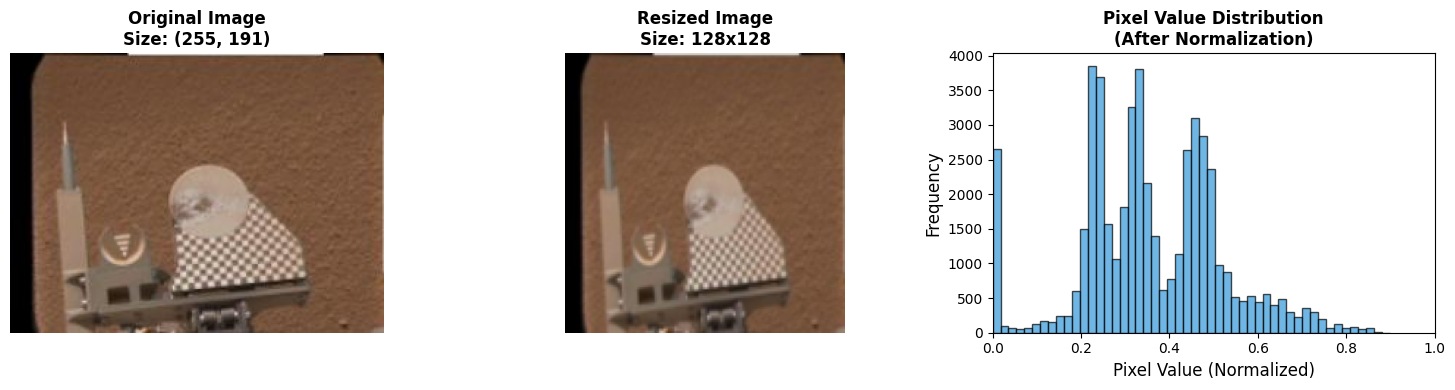


PREPROCESSING CONFIGURATION
Target image size: 128x128 pixels
Number of channels: 3 (RGB)
Number of classes: 24
Input shape: (128, 128, 3)
Pixel value range: [0.0, 1.0]


In [24]:
# Define preprocessing parameters
IMG_SIZE = 128  # Target size for all images
NUM_CLASSES = len(class_names)
NUM_CHANNELS = 3  # RGB images

def preprocess_image(img_path, target_size=IMG_SIZE):
    """
    Preprocess a single image:
    1. Load image
    2. Convert to RGB (if needed)
    3. Resize to target size
    4. Normalize pixel values to [0, 1]
    """
    img = Image.open(img_path)
    
    # Convert to RGB if necessary
    if img.mode != 'RGB':
        img = img.convert('RGB')
    
    # Resize to target size
    img = img.resize((target_size, target_size), Image.Resampling.BILINEAR)
    
    # Convert to numpy array and normalize
    img_array = np.array(img, dtype=np.float32) / 255.0
    
    return img_array

# Demonstrate preprocessing on a sample image
sample_path = os.path.join(BASE_PATH, train_images[0])
original_img = Image.open(sample_path)
preprocessed_img = preprocess_image(sample_path)

fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# Original image
axes[0].imshow(original_img)
axes[0].set_title(f'Original Image\nSize: {original_img.size}', fontsize=12, fontweight='bold')
axes[0].axis('off')

# Resized image
axes[1].imshow(preprocessed_img)
axes[1].set_title(f'Resized Image\nSize: {IMG_SIZE}x{IMG_SIZE}', fontsize=12, fontweight='bold')
axes[1].axis('off')

# Pixel value distribution
axes[2].hist(preprocessed_img.flatten(), bins=50, color='#3498db', edgecolor='black', alpha=0.7)
axes[2].set_xlabel('Pixel Value (Normalized)', fontsize=12)
axes[2].set_ylabel('Frequency', fontsize=12)
axes[2].set_title('Pixel Value Distribution\n(After Normalization)', fontsize=12, fontweight='bold')
axes[2].set_xlim(0, 1)

original_img.close()
plt.tight_layout()
plt.show()

print("\n" + "=" * 50)
print("PREPROCESSING CONFIGURATION")
print("=" * 50)
print(f"Target image size: {IMG_SIZE}x{IMG_SIZE} pixels")
print(f"Number of channels: {NUM_CHANNELS} (RGB)")
print(f"Number of classes: {NUM_CLASSES}")
print(f"Input shape: ({IMG_SIZE}, {IMG_SIZE}, {NUM_CHANNELS})")
print(f"Pixel value range: [0.0, 1.0]")
print("=" * 50)

### 1.8 EDA Summary

| Property | Value |
|----------|-------|
| **Dataset Name** | Mars Surface Image (Curiosity rover) Labeled Data Set |
| **Total Images** | 6,691 |
| **Training Set** | 3,747 images (56.0%) |
| **Validation Set** | 1,641 images (24.5%) |
| **Test Set** | 1,306 images (19.5%) |
| **Number of Classes** | 24 |
| **Original Image Size** | ~256×256 pixels (variable) |
| **Target Size** | 128×128 pixels |
| **Color Channels** | 3 (RGB) |
| **Pixel Normalization** | [0, 255] → [0, 1] |

**Key Observations:**
1. The dataset shows significant **class imbalance**, with some classes having many more images than others
2. Images are approximately **256×256 pixels** in their original form
3. All images are **color (RGB)** images captured by Mars rover instruments
4. The temporal split (by sol) provides a realistic evaluation scenario

**Implications for CNN Design:**
- Class imbalance may require techniques like class weighting or data augmentation
- Convolutional layers are appropriate given the spatial structure of the images
- Color channels (RGB) may contain important discriminative information for Mars terrain classification